In [ ]:
import jax
import jax.numpy as jnp
import time
import ptyrodactyl.electrons as pte
import ptyrodactyl.tools as ptt
from jaxtyping import Array, Float, Shaped, Int, Complex
import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
key = jax.random.PRNGKey(0)

In [ ]:
beam_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)
slice_test_s = jax.random.normal(key, shape=(256, 256), dtype=jnp.complex64)

beam_test_m = jax.random.normal(key, shape=(256, 256, 32), dtype=jnp.complex64)
slice_test_m = jax.random.normal(key, shape=(256, 256, 500), dtype=jnp.complex64)

In [ ]:
def jax_test(a):
    b = a**2
    c = jnp.log10(b + a)
    return c

In [ ]:
test_arr = 2.08
grad_func = jax.grad(jax_test)
jax_test(test_arr), grad_func(test_arr)

(Array(0.80661405, dtype=float64), Array(0.34980013, dtype=float64))

In [ ]:
test_func_ss = jax.jit(pte.cbed)
test_func_ns = jax.jit(pte.cbed_no_slice)

In [ ]:
help(pte.cbed)

Help on function cbed in module ptyrodactyl.electrons.forward:

cbed(
    pot_slice: jaxtyping.Complex[Array, 'H W *S'],
    beam: jaxtyping.Complex[Array, 'H W *M'],
    slice_thickness: jaxtyping.Float[Array, '*'],
    voltage_kV: jaxtyping.Float[Array, '*'],
    calib_ang: jaxtyping.Float[Array, '*']
) -> jaxtyping.Float[Array, 'H W']
    Calculates the CBED pattern for single/multiple slices
    and single/multiple beam modes. This function computes
    the Convergent Beam Electron Diffraction (CBED) pattern
    by propagating one or more beam modes through one or
    more potential slices.

    Args:
    - `pot_slice` (Complex[Array, "H W *S"]):
        The potential slice(s). H and W are height and width,
        S is the number of slices (optional).
    - `beam` (Complex[Array, "H W *M"]):
        The electron beam mode(s).
        M is the number of modes (optional).
    - `slice_thickness` (Float[Array, "*"]):
        The thickness of each slice in angstroms.
    - `voltage_kV

In [ ]:
%timeit test_func_ss(slice_test_s, beam_test_s, 1, 60.00, 0.1)

256 μs ± 74.8 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
beam_test_m.shape, slice_test_m.shape

((256, 256, 32), (256, 256, 500))

In [ ]:
%timeit test_func_ss(slice_test_s, beam_test_m, 1, 60.00, 0.1)

2.57 ms ± 23.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
%timeit test_func_ss(slice_test_m, beam_test_s, 1, 60.00, 0.1)

33.2 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit test_func_ss(slice_test_m, beam_test_m, 1, 60.00, 0.1)

909 ms ± 67.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
yy, xx = jnp.mgrid[-20:20, -20:20]
pos_list = jnp.transpose(jnp.array((yy.ravel(), xx.ravel())))
del yy, xx

In [ ]:
devices = jax.devices()
devices

[CudaDevice(id=0),
 CudaDevice(id=1),
 CudaDevice(id=2),
 CudaDevice(id=3),
 CudaDevice(id=4),
 CudaDevice(id=5),
 CudaDevice(id=6),
 CudaDevice(id=7)]

In [ ]:
help(pte.stem_4d)

Help on PjitFunction in module ptyrodactyl.electrons.forward:

stem_4d(
    pot_slice: jaxtyping.Complex[Array, 'H W S'],
    beam: jaxtyping.Complex[Array, 'H W M'],
    pos_list: jaxtyping.Float[Array, 'P 2'],
    slice_thickness: float,
    voltage_kV: float,
    calib_ang: float
) -> jaxtyping.Float[Array, 'P H W']
    Calculates the 4D-STEM pattern for multiple probe positions with sharding.

    Args:
    - `pot_slice` (Complex[Array, "H W S"]):
        The potential slices.
    - `beam` (Complex[Array, "H W M"]):
        The electron beam modes.
    - `pos_list` (Float[Array, "P 2"]):
        List of (y, x) probe positions in pixels.
    - `slice_thickness` (float):
        The thickness of each slice in angstroms.
    - `voltage_kV` (float):
        The accelerating voltage in kilovolts.
    - `calib_ang` (float):
        The calibration in angstroms.
    - `mesh` (Mesh):
        The device mesh for sharding.

    Returns:
    - stem_pattern (Float[Array, "P H W"]): The calcula

In [ ]:
sharded_pot_slice = ptt.shard_array(
    jnp.atleast_3d(slice_test_s), shard_axes=[-1, -1, -1], devices=devices
)
sharded_beam = ptt.shard_array(
    jnp.atleast_3d(beam_test_s), shard_axes=[-1, -1, -1], devices=devices
)
sharded_pos_list = ptt.shard_array(pos_list, shard_axes=[-1, -1], devices=devices)

In [ ]:
t = time.time()
pte.stem_4d(
    jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64),
    jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64),
    pos_list,
    1.00,
    60.000,
    0.1,
)
elapsed = time.time() - t
print(elapsed)

1.3497180938720703


In [ ]:
%timeit pte.stem_4d(jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64), jax.random.normal(key, shape=(100, 100, 1), dtype=jnp.complex64), pos_list, 1.00, 60.000, 0.1)

37.1 ms ± 27.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
import numpy as np

In [ ]:
test_data = np.load("../data/mos2_simul256.npz")
test_data.keys()

KeysView(NpzFile '../data/mos2_simul256.npz' with keys: data4D, probe_positions, probe, stem_images, ground_truth...)

<matplotlib.image.AxesImage>

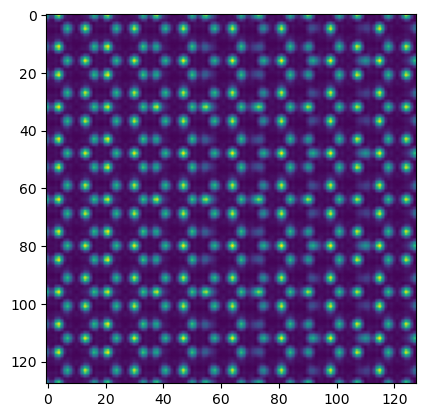

In [ ]:
plt.imshow(test_data["stem_images"][:, :, 2])

In [ ]:
for k in test_data.files:
    print(k)

data4D
probe_positions
probe
stem_images
ground_truth
defocus


In [ ]:
data_4Dr = test_data["data4D"]
data_4Dr = data_4Dr.reshape(-1, data_4Dr.shape[2], data_4Dr.shape[3])
probe_r = test_data["probe"]
positions_r = test_data["probe_positions"]

In [ ]:
yy, xx = jnp.meshgrid(positions_r[:, 0], positions_r[:, 1])
positions_r = jnp.transpose(jnp.array((yy.ravel(), xx.ravel())))
positions_r.shape

(676, 2)

In [ ]:
object_256 = np.load("../data/full_object_256.npy")

<matplotlib.image.AxesImage>

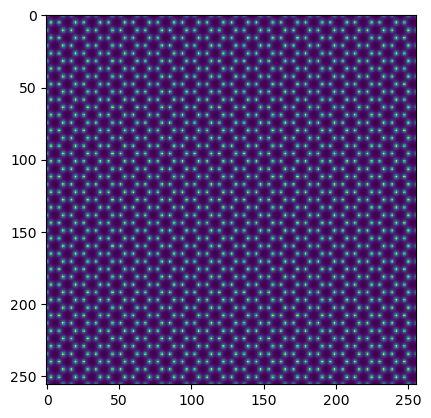

In [ ]:
plt.imshow(np.angle(object_256))

In [ ]:
test_object = jnp.ones_like(object_256, dtype=jnp.complex128)

In [ ]:
test_4Dr = pte.stem_4d(
    object_256, jnp.atleast_3d(probe_r), positions_r, 1.00, 60.000, 0.1
)

<matplotlib.image.AxesImage>

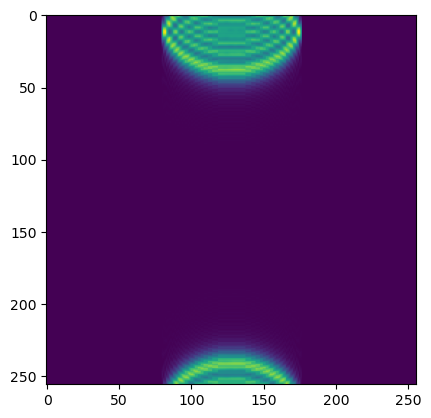

In [ ]:
plt.imshow(test_4Dr[100, :, :])

In [ ]:
results = pte.single_slice_ptychography(experimental_4dstem=data_4Dr, initial_pot_slice=test_object, initial_beam=probe_r, post_list=positions_r, 1.00, 60.000, 0.001, num_iterations=20)

SyntaxError: positional argument follows keyword argument (3545572143.py, line 1)